# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

# Standard library
from pathlib import Path
import pprint

# Third-party libraries
import duckdb
import fireducks.pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
from matplotlib import rcParams
from sklearn.covariance import EmpiricalCovariance

rcParams["text.usetex"] = True

# Custom osbad library for anomaly detection
import osbad.config as bconf
import osbad.hyperparam as hp
import osbad.modval as modval
import osbad.stats as bstats
import osbad.viz as bviz
from osbad.database import BenchDB
from osbad.model import ModelRunner

# Import dataset

In [2]:
# Define a global variable to save fig output
# The definition of PIPELINE_OUTPUT_DIR can be
# found in config.py
PIPELINE_OUTPUT_DIR = bconf.PIPELINE_OUTPUT_DIR

In [3]:
# Path to the DuckDB instance:
# "tohoku_benchmark_dataset.db" inside the database folder
db_filepath = (
    Path.cwd()
    .parent.parent.parent
    .joinpath("database","tohoku_benchmark_dataset.db"))

## Get unique cell labels from training dataset

* There are 10 cells in the Tohoku dataset. We only want to use the first five cell experimental dataset for training, and the last five cell experimental dataset for test purposes.

In [4]:
# Create a DuckDB connection
con = duckdb.connect(
    db_filepath,
    read_only=True)

# Load all training dataset from duckdb
df_duckdb = con.execute(
    "SELECT * FROM df_tohoku_dataset").fetchdf()

# Drop the additional index column
df_duckdb = df_duckdb.drop(
    columns="__index_level_0__",
    errors="ignore")

# Take only the first five cells for training
unique_cell_index_train = df_duckdb["cell_index"].unique()[:5]
print(unique_cell_index_train)

training_cell_count = len(unique_cell_index_train)
print(f"Training cell count: {training_cell_count}")

['cell_num_1' 'cell_num_2' 'cell_num_3' 'cell_num_4' 'cell_num_5']
Training cell count: 5


## Select data based on cell_index

In [5]:
# Get the cell-ID from cell_inventory
selected_cell_label = "cell_num_1"
cell_num = selected_cell_label[-1]

# Create a subfolder to store fig output
# corresponding to each cell-index
selected_cell_artifacts_dir = bconf.artifacts_output_dir(
    selected_cell_label)

# Filter dataset for specific selected cell only
df_selected_cell = df_duckdb[
    df_duckdb["cell_index"] == selected_cell_label]

# Import the BenchDB class
benchdb = BenchDB(
    db_filepath,
    selected_cell_label)

## Drop labels

In [6]:
# Drop the outlier labels
df_selected_cell_without_labels = df_selected_cell.drop(
    "outlier", axis=1).reset_index(drop=True)

df_selected_cell_without_labels                                 

,discharge_capacity,voltage,cycle_index,cell_index
0,0.000077,3.617995,0,cell_num_1
1,0.231343,3.572679,0,cell_num_1
2,0.462615,3.567599,0,cell_num_1
3,0.693891,3.563376,0,cell_num_1
4,0.925169,3.559585,0,cell_num_1
...,...,...,...,...
158807,37.700096,3.067416,476,cell_num_1
158808,37.931385,3.066397,476,cell_num_1
158809,38.162678,3.065279,476,cell_num_1
158810,38.393963,3.064079,476,cell_num_1


## Plot cycle capacity fade without labels

In [7]:
# Calculate maximum capacity per cycle
max_cap_per_cycle = (
    df_selected_cell_without_labels
        .groupby(["cycle_index"])["discharge_capacity"].max())
max_cap_per_cycle.name = "max_discharge_capacity"

unique_cycle_index = (
    df_selected_cell_without_labels["cycle_index"].unique())

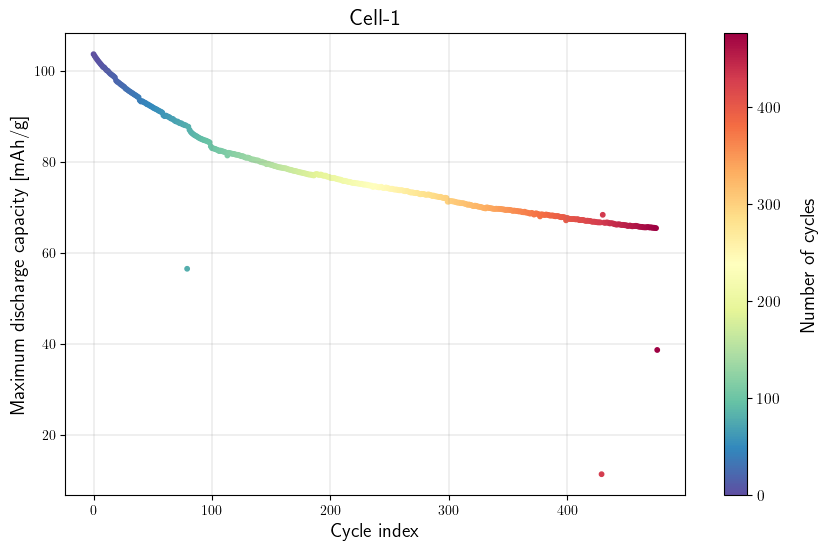

In [8]:
axplot = bviz.plot_cycle_data(
    xseries=unique_cycle_index,
    yseries=max_cap_per_cycle,
    cycle_index_series=unique_cycle_index)

axplot.set_xlabel(
    r"Cycle index",
    fontsize=14)
axplot.set_ylabel(
    r"Maximum discharge capacity [mAh/g]",
    fontsize=14)

axplot.set_title(
    f"Cell-{cell_num}",
    fontsize=16)

output_fig_filename = (
    "cycling_data_without_labels_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Feature transformation

In the Tohoku's dataset, we want to track the sudden and unintended capacity drop over the cycle life. Therefore, for this purpose, the features we are using are

* Cycle index
* Maximum discharge capacity
* Normalized Mahalanobis distance

## Create Xfeat for Mahalanobis distance calculation

* The Mahalanobis distance is calculated from both the cycle index as well as the maximum discharge capacity.

In [9]:
df_cycle_index = pd.Series(
    unique_cycle_index,
    name="cycle_index")

# Input features for Mahalanobis distance
df_features_per_cell = pd.concat(
    [df_cycle_index,
     max_cap_per_cycle],
    axis=1)

df_features_per_cell

,cycle_index,max_discharge_capacity
0,0,103.695534
1,1,103.262245
2,2,102.863579
3,3,102.514778
4,4,102.167763
...,...,...
472,472,65.497063
473,473,65.533783
474,474,65.472183
475,475,65.430740


## Feature: Normalized Mahalanobis distance

In [10]:
Xfeat = df_features_per_cell.values

# Calculate Mahalanobis distance based on cycle_index and max_discharge_capacity
cov = EmpiricalCovariance().fit(Xfeat)
mahal_dist = cov.mahalanobis(Xfeat)

df_maha_dist = pd.Series(
    mahal_dist,
    name="mahal_dist")

# Merge calculated mahalanobis distance
df_merge_features = pd.concat(
    [df_features_per_cell,
     df_maha_dist], axis=1)

# Calculate maximum mahal_dist to 
# normalize the distance calculation
max_mahal_dist = (
    df_merge_features["mahal_dist"].max())

df_merge_features["norm_mahal_dist"] = (
    df_merge_features["mahal_dist"]/max_mahal_dist)

selected_feature_cols = (
    "max_discharge_capacity",
    "norm_mahal_dist")

In [11]:
df_merge_features

,cycle_index,max_discharge_capacity,mahal_dist,norm_mahal_dist
0,0,103.695534,9.673250,0.062985
1,1,103.262245,9.211937,0.059981
2,2,102.863579,8.804678,0.057329
3,3,102.514778,8.464507,0.055114
4,4,102.167763,8.135068,0.052969
...,...,...,...,...
472,472,65.497063,4.012342,0.026125
473,473,65.533783,4.089273,0.026626
474,474,65.472183,4.116929,0.026806
475,475,65.430740,4.154986,0.027054


# Hyperparameter tuning

## Create optuna study

In [12]:
total_cycle_count = len(df_selected_cell["cycle_index"].unique())

hp_config_iforest = {
    "contamination": {"low": 0.0, "high": 0.5},
    "n_estimators": {"low": 100, "high": 500},
    "max_samples": {"low": 100, "high": total_cycle_count},
    "threshold": {"low": 0.0, "high": 1.0}
}

iforest_hp_config_filepath = (
    Path.cwd()
    .parent.parent.parent
    .joinpath(
        "machine_learning",
        "hp_config_schema",
        "tohoku_hp_config",
        "iforest_hp_config.json"))

bconf.create_json_hp_config(
    iforest_hp_config_filepath,
    hp_dict=hp_config_iforest)

bconf.load_json_hp_config(
    iforest_hp_config_filepath)

{'contamination': {'low': 0.0, 'high': 0.5},
 'n_estimators': {'low': 100, 'high': 500},
 'max_samples': {'low': 100, 'high': 477},
 'threshold': {'low': 0.0, 'high': 1.0}}

In [13]:
# Reload the hp module to refresh in-memory variables
# especially after updating parameters
from importlib import reload
reload(hp)

# Check if the schema in the script has been updated 
# based on the current constraints specified 
# from the notebook
print("Current hyperparameter config:")
print(hp.IFOREST_HP_CONFIG)
print("-"*70)

# Instantiate an optuna study for iForest model
sampler = optuna.samplers.TPESampler(seed=42)

if_study = optuna.create_study(
    study_name="iforest_hyperparam",
    sampler=sampler,
    directions=["maximize","maximize"])

if_study.optimize(
    lambda trial: hp.objective(
        trial,
        model_id="iforest",
        df_feature_dataset=df_merge_features,
        selected_feature_cols=selected_feature_cols,
        df_benchmark_dataset=df_selected_cell,
        selected_cell_label=selected_cell_label),
    n_trials=20)

[I 2025-10-06 16:01:08,908] A new study created in memory with name: iforest_hyperparam


Current hyperparameter config:
{'contamination': {'low': 0.0, 'high': 0.5}, 'n_estimators': {'low': 100, 'high': 500}, 'max_samples': {'low': 100, 'high': 477}, 'threshold': {'low': 0.0, 'high': 1.0}}
----------------------------------------------------------------------


[I 2025-10-06 16:01:09,922] Trial 0 finished with values: [1.0, 0.75] and parameters: {'contamination': 0.18727005942368125, 'n_estimators': 481, 'max_samples': 376, 'threshold': 0.5986584841970366}.
[I 2025-10-06 16:01:10,408] Trial 1 finished with values: [0.6666666666666666, 1.0] and parameters: {'contamination': 0.07800932022121826, 'n_estimators': 162, 'max_samples': 121, 'threshold': 0.8661761457749352}.
[I 2025-10-06 16:01:11,204] Trial 2 finished with values: [0.3333333333333333, 1.0] and parameters: {'contamination': 0.3005575058716044, 'n_estimators': 383, 'max_samples': 107, 'threshold': 0.9699098521619943}.
[I 2025-10-06 16:01:11,721] Trial 3 finished with values: [1.0, 0.02912621359223301] and parameters: {'contamination': 0.41622132040021087, 'n_estimators': 185, 'max_samples': 168, 'threshold': 0.18340450985343382}.
[I 2025-10-06 16:01:12,534] Trial 4 finished with values: [1.0, 0.08333333333333333] and parameters: {'contamination': 0.15212112147976886, 'n_estimators': 3

## Aggregate best trials

In [14]:
schema_iforest = {
    "threshold": "median",
    "contamination": "median",
    "n_estimators": "median_int",
    "max_samples": "median_int",
}

df_iforest_hyperparam = hp.aggregate_best_trials(
    if_study,
    cell_label=selected_cell_label,
    model_id="iforest",
    schema=schema_iforest)

df_iforest_hyperparam

,ml_model,cell_index,threshold,contamination,n_estimators,max_samples
0,iforest,cell_num_1,0.732143,0.063146,321,445


## Evaluate percentage of perfect recall and precision score

In [15]:
recall_score_pct, precision_score_pct = hp.evaluate_hp_perfect_score_pct(
    model_study=if_study)

Total trial count: 20
Trial 0:
Recall score per trial: 1.0
Precision score per trial: 0.75
----------------------------------------------------------------------
Trial 1:
Recall score per trial: 0.6666666666666666
Precision score per trial: 1.0
----------------------------------------------------------------------
Trial 2:
Recall score per trial: 0.3333333333333333
Precision score per trial: 1.0
----------------------------------------------------------------------
Trial 3:
Recall score per trial: 1.0
Precision score per trial: 0.02912621359223301
----------------------------------------------------------------------
Trial 4:
Recall score per trial: 1.0
Precision score per trial: 0.08333333333333333
----------------------------------------------------------------------
Trial 5:
Recall score per trial: 1.0
Precision score per trial: 0.12
----------------------------------------------------------------------
Trial 6:
Recall score per trial: 1.0
Precision score per trial: 0.27272727272727

## Plot pareto front

/home/mei-chin-pang/02_academics/osbad_development/osbad/src/osbad/hyperparam.py:903: ExperimentalWarning: optuna.visualization.matplotlib._pareto_front.plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  axplot = optuna.visualization.matplotlib.plot_pareto_front(


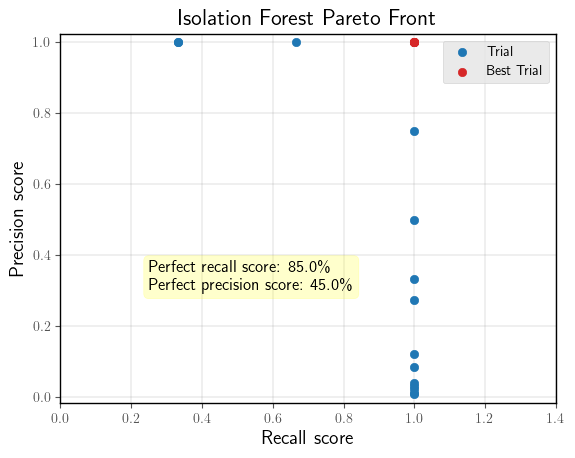

In [16]:
hp.plot_pareto_front(
    if_study,
    selected_cell_label,
    fig_title="Isolation Forest Pareto Front")

plt.show()

## Export current hyperparameters to CSV 

In [17]:
# Export current hyperparameters to CSV
hyperparam_filepath =  PIPELINE_OUTPUT_DIR.joinpath(
    "hyperparams_iforest_tohoku.csv")

hp.export_current_hyperparam(
    df_iforest_hyperparam,
    selected_cell_label,
    export_csv_filepath=hyperparam_filepath,
    if_exists="replace")

Have the hyperparam for cell_num_1 been evaluated?
True
**********************************************************************
Replacing existing rows for cell_num_1.
Hyperparameters for cell_num_1 have been replaced in the CSV file.


,ml_model,cell_index,threshold,contamination,n_estimators,max_samples
0,iforest,cell_num_2,0.644296,0.395732,281,429
1,iforest,cell_num_3,0.551524,0.202986,289,234
2,iforest,cell_num_4,0.403156,0.235096,324,105
3,iforest,cell_num_5,0.521962,0.422295,239,321
4,iforest,cell_num_1,0.732143,0.063146,321,445


# Train model with best trial parameters

## Load best trial parameters from CSV output

In [18]:
# Test reading from exported metrics
df_hyperparam_from_csv = pd.read_csv(hyperparam_filepath)

df_param_per_cell = df_hyperparam_from_csv[
    df_hyperparam_from_csv["cell_index"] == selected_cell_label]
df_param_per_cell

,ml_model,cell_index,threshold,contamination,n_estimators,max_samples
4,iforest,cell_num_1,0.732143,0.063146,321,445


## Create a dict for best trial parameters

In [19]:
param_dict = df_param_per_cell.iloc[0].to_dict()
pprint.pp(param_dict)

{'ml_model': 'iforest',
 'cell_index': 'cell_num_1',
 'threshold': 0.7321432280768185,
 'contamination': 0.0631460561046617,
 'n_estimators': 321,
 'max_samples': 445}


## Run the model with best trial parameters

In [20]:
cfg = hp.MODEL_CONFIG["iforest"]

runner = ModelRunner(
    cell_label=selected_cell_label,
    df_input_features=df_merge_features,
    selected_feature_cols=selected_feature_cols
)

Xdata = runner.create_model_x_input()

model = cfg.model_param(param_dict)
print(model)
model.fit(Xdata)
proba = model.predict_proba(Xdata)

pred_outlier_indices, pred_outlier_score = runner.pred_outlier_indices_from_proba(
    proba=proba,
    threshold=param_dict["threshold"],
    outlier_col=cfg.proba_col
)

pred_outlier_indices, pred_outlier_score

IForest(behaviour='new', bootstrap=False, contamination=0.0631460561046617,
    max_features=1.0, max_samples=445, n_estimators=321, n_jobs=-1,
    random_state=42, verbose=0)


(array([ 79, 429, 476]), array([0.85690627, 1.        , 0.84648983]))

## Get df_outliers_pred

In [21]:
df_outliers_pred = (df_merge_features[
    df_merge_features["cycle_index"]
    .isin(pred_outlier_indices)].copy())

df_outliers_pred["outlier_prob"] = pred_outlier_score
df_outliers_pred

,cycle_index,max_discharge_capacity,mahal_dist,norm_mahal_dist,outlier_prob
79,79,56.489555,53.625261,0.349166,0.856906
429,429,11.293598,153.580929,1.000000,1.000000
476,476,38.625252,29.740101,0.193644,0.846490


## Predict anomaly score map

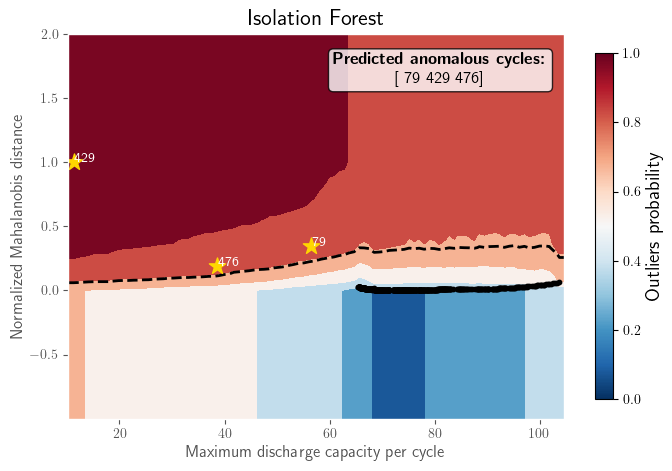

In [22]:
axplot = runner.predict_anomaly_score_map(
    selected_model=model,
    model_name="Isolation Forest",
    xoutliers=df_outliers_pred["max_discharge_capacity"],
    youtliers=df_outliers_pred["norm_mahal_dist"],
    pred_outliers_index=pred_outlier_indices,
    threshold=param_dict["threshold"],
    square_grid=False,
    grid_offset=1
)

axplot.set_xlabel(
    r"Maximum discharge capacity per cycle",
    fontsize=12)
axplot.set_ylabel(
    r"Normalized Mahalanobis distance",
    fontsize=12)

output_fig_filename = (
    "isolation_forest_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Model performance evaluation

In [23]:
df_eval_outlier = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=pred_outlier_indices)

## Confusion matrix

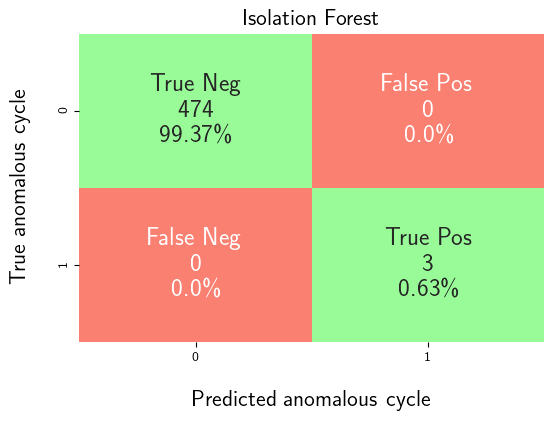

In [24]:
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier["true_outlier"],
    y_pred=df_eval_outlier["pred_outlier"])

axplot.set_title(
    "Isolation Forest",
    fontsize=16)

output_fig_filename = (
    "conf_matrix_iforest_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Evaluate model performance

In [25]:
df_current_eval_metrics = modval.eval_model_performance(
    model_name="iforest",
    selected_cell_label=selected_cell_label,
    df_eval_outliers=df_eval_outlier)

df_current_eval_metrics

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
MCC-score: 1.0
****************************************************************************************************


,ml_model,cell_index,accuracy,precision,recall,f1_score,mcc_score
0,iforest,cell_num_1,1.0,1.0,1.0,1.0,1.0


## Export model performance metrics to CSV output

In [26]:
# Export current metrics to CSV
hyperparam_eval_filepath =  Path.cwd().joinpath(
    "eval_metrics_hp_single_cell_tohoku.csv")

hp.export_current_model_metrics(
    model_name="iforest",
    selected_cell_label=selected_cell_label,
    df_current_eval_metrics=df_current_eval_metrics,
    export_csv_filepath=hyperparam_eval_filepath,
    if_exists="replace")

Have the metrics for iforest on cell cell_num_1 been evaluated before?
True
----------------------------------------------------------------------
Replacing existing row for iforest, cell_num_1.
Metrics for iforest, cell_num_1 have been replaced in the CSV file.


,ml_model,cell_index,accuracy,precision,recall,f1_score,mcc_score
0,knn,cell_num_1,1.0,1.0,1.0,1.0,1.0
1,iforest,cell_num_1,1.0,1.0,1.0,1.0,1.0


# Finally: check with true labels

## Plot cycle data with labels

True outlier cycle index:
[ 79 429 476]


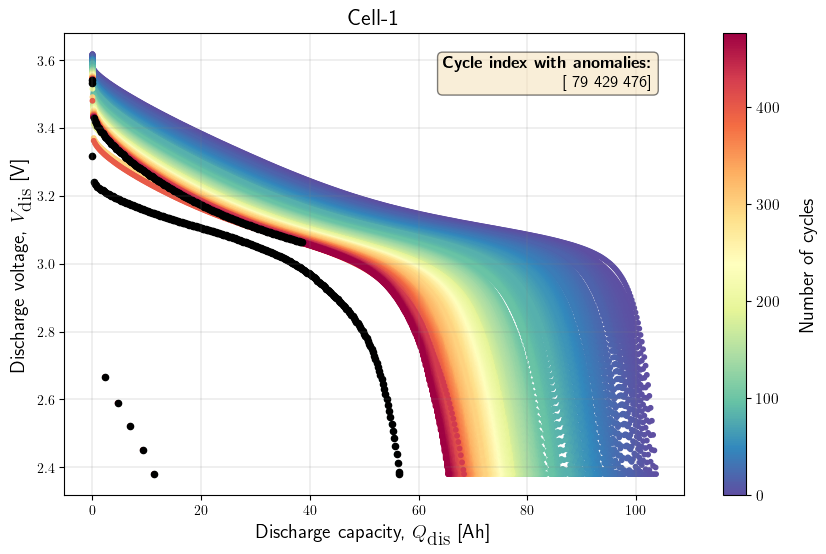

In [27]:
# Extract true outliers cycle index from benchmarking dataset
true_outlier_cycle_index = benchdb.get_true_outlier_cycle_index(
    df_selected_cell)
print(f"True outlier cycle index:")
print(true_outlier_cycle_index)

# Plot cell data with true anomalies
# If the true outlier cycle index is not known,
# cycling data will be plotted without labels
axplot = benchdb.plot_cycle_data(
    df_selected_cell_without_labels,
    true_outlier_cycle_index)

axplot.set_title(
    f"Cell-{cell_num}",
    fontsize=16)

output_fig_filename = (
    "cycling_data_with_labels_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Plot capacity fade with labels

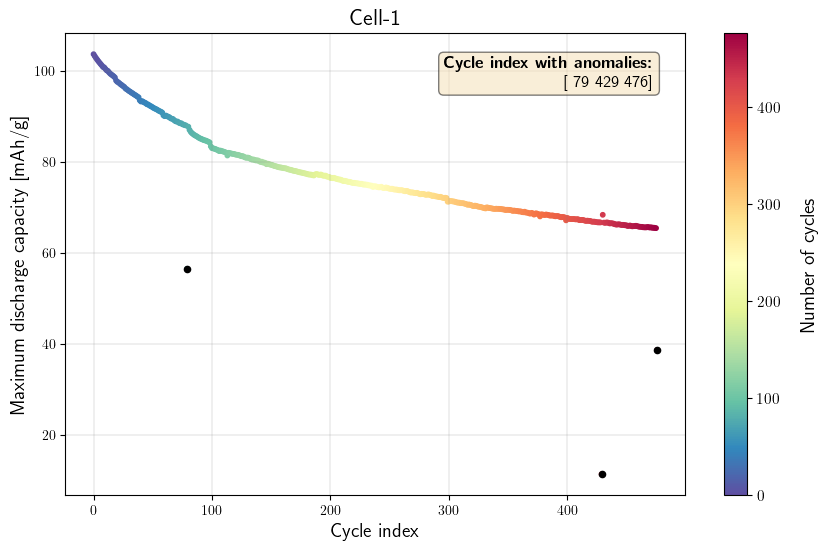

In [28]:
df_true_outliers = (df_merge_features[
    df_merge_features["cycle_index"]
    .isin(true_outlier_cycle_index)].copy())

axplot = bviz.plot_cycle_data(
    xseries=unique_cycle_index,
    yseries=max_cap_per_cycle,
    cycle_index_series=unique_cycle_index,
    xoutlier=df_true_outliers["cycle_index"],
    youtlier=df_true_outliers["max_discharge_capacity"])

axplot.set_xlabel(
    r"Cycle index",
    fontsize=14)
axplot.set_ylabel(
    r"Maximum discharge capacity [mAh/g]",
    fontsize=14)

axplot.set_title(
    f"Cell-{cell_num}",
    fontsize=16)

# Create textbox to annotate anomalous cycle
textstr = '\n'.join((
    r"\textbf{Cycle index with anomalies:}",
    f"{true_outlier_cycle_index}"))

# properties for bbox
props = dict(
    boxstyle='round',
    facecolor='wheat',
    alpha=0.5)

# first 0.95 corresponds to the left right alignment starting
# from left, second 0.95 corresponds to up down alignment
# starting from bottom
axplot.text(
    0.95, 0.95,
    textstr,
    transform=axplot.transAxes,
    fontsize=12,
    # ha means right alignment of the text
    ha="right", va='top',
    bbox=props)

output_fig_filename = (
    "cap_fade_with_labels_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()